# Example of usage Spark OCR for Tables Recognition from PDF

This notebook demonstrate end-to-end pipeline for extract tabular data from image-based documents.

For more details about table recognition please read: [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

## Install spark-ocr python packge

Need to specify:
- secret
- license
- aws credentials

In [1]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"
pdf_path = "./data/tab_pdfs/budget.pdf"

In [2]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [ ]:
# install from local package 
#%pip install ../../python/dist/spark-ocr-3.6.0+spark30.tar.gz

In [ ]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [3]:
import os
import sys

if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['SPARK_OCR_LICENSE'] = license
    
if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [4]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path, nlp_version="3.1.1")

spark

Spark version: 3.0.2
Spark NLP version: 3.0.1
Spark OCR version: 3.5.0



## Read PDF and display it


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/tab_pdfs/budget.pdf
    Resolution: 300 dpi
    Width: 3507 px
    Height: 2480 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


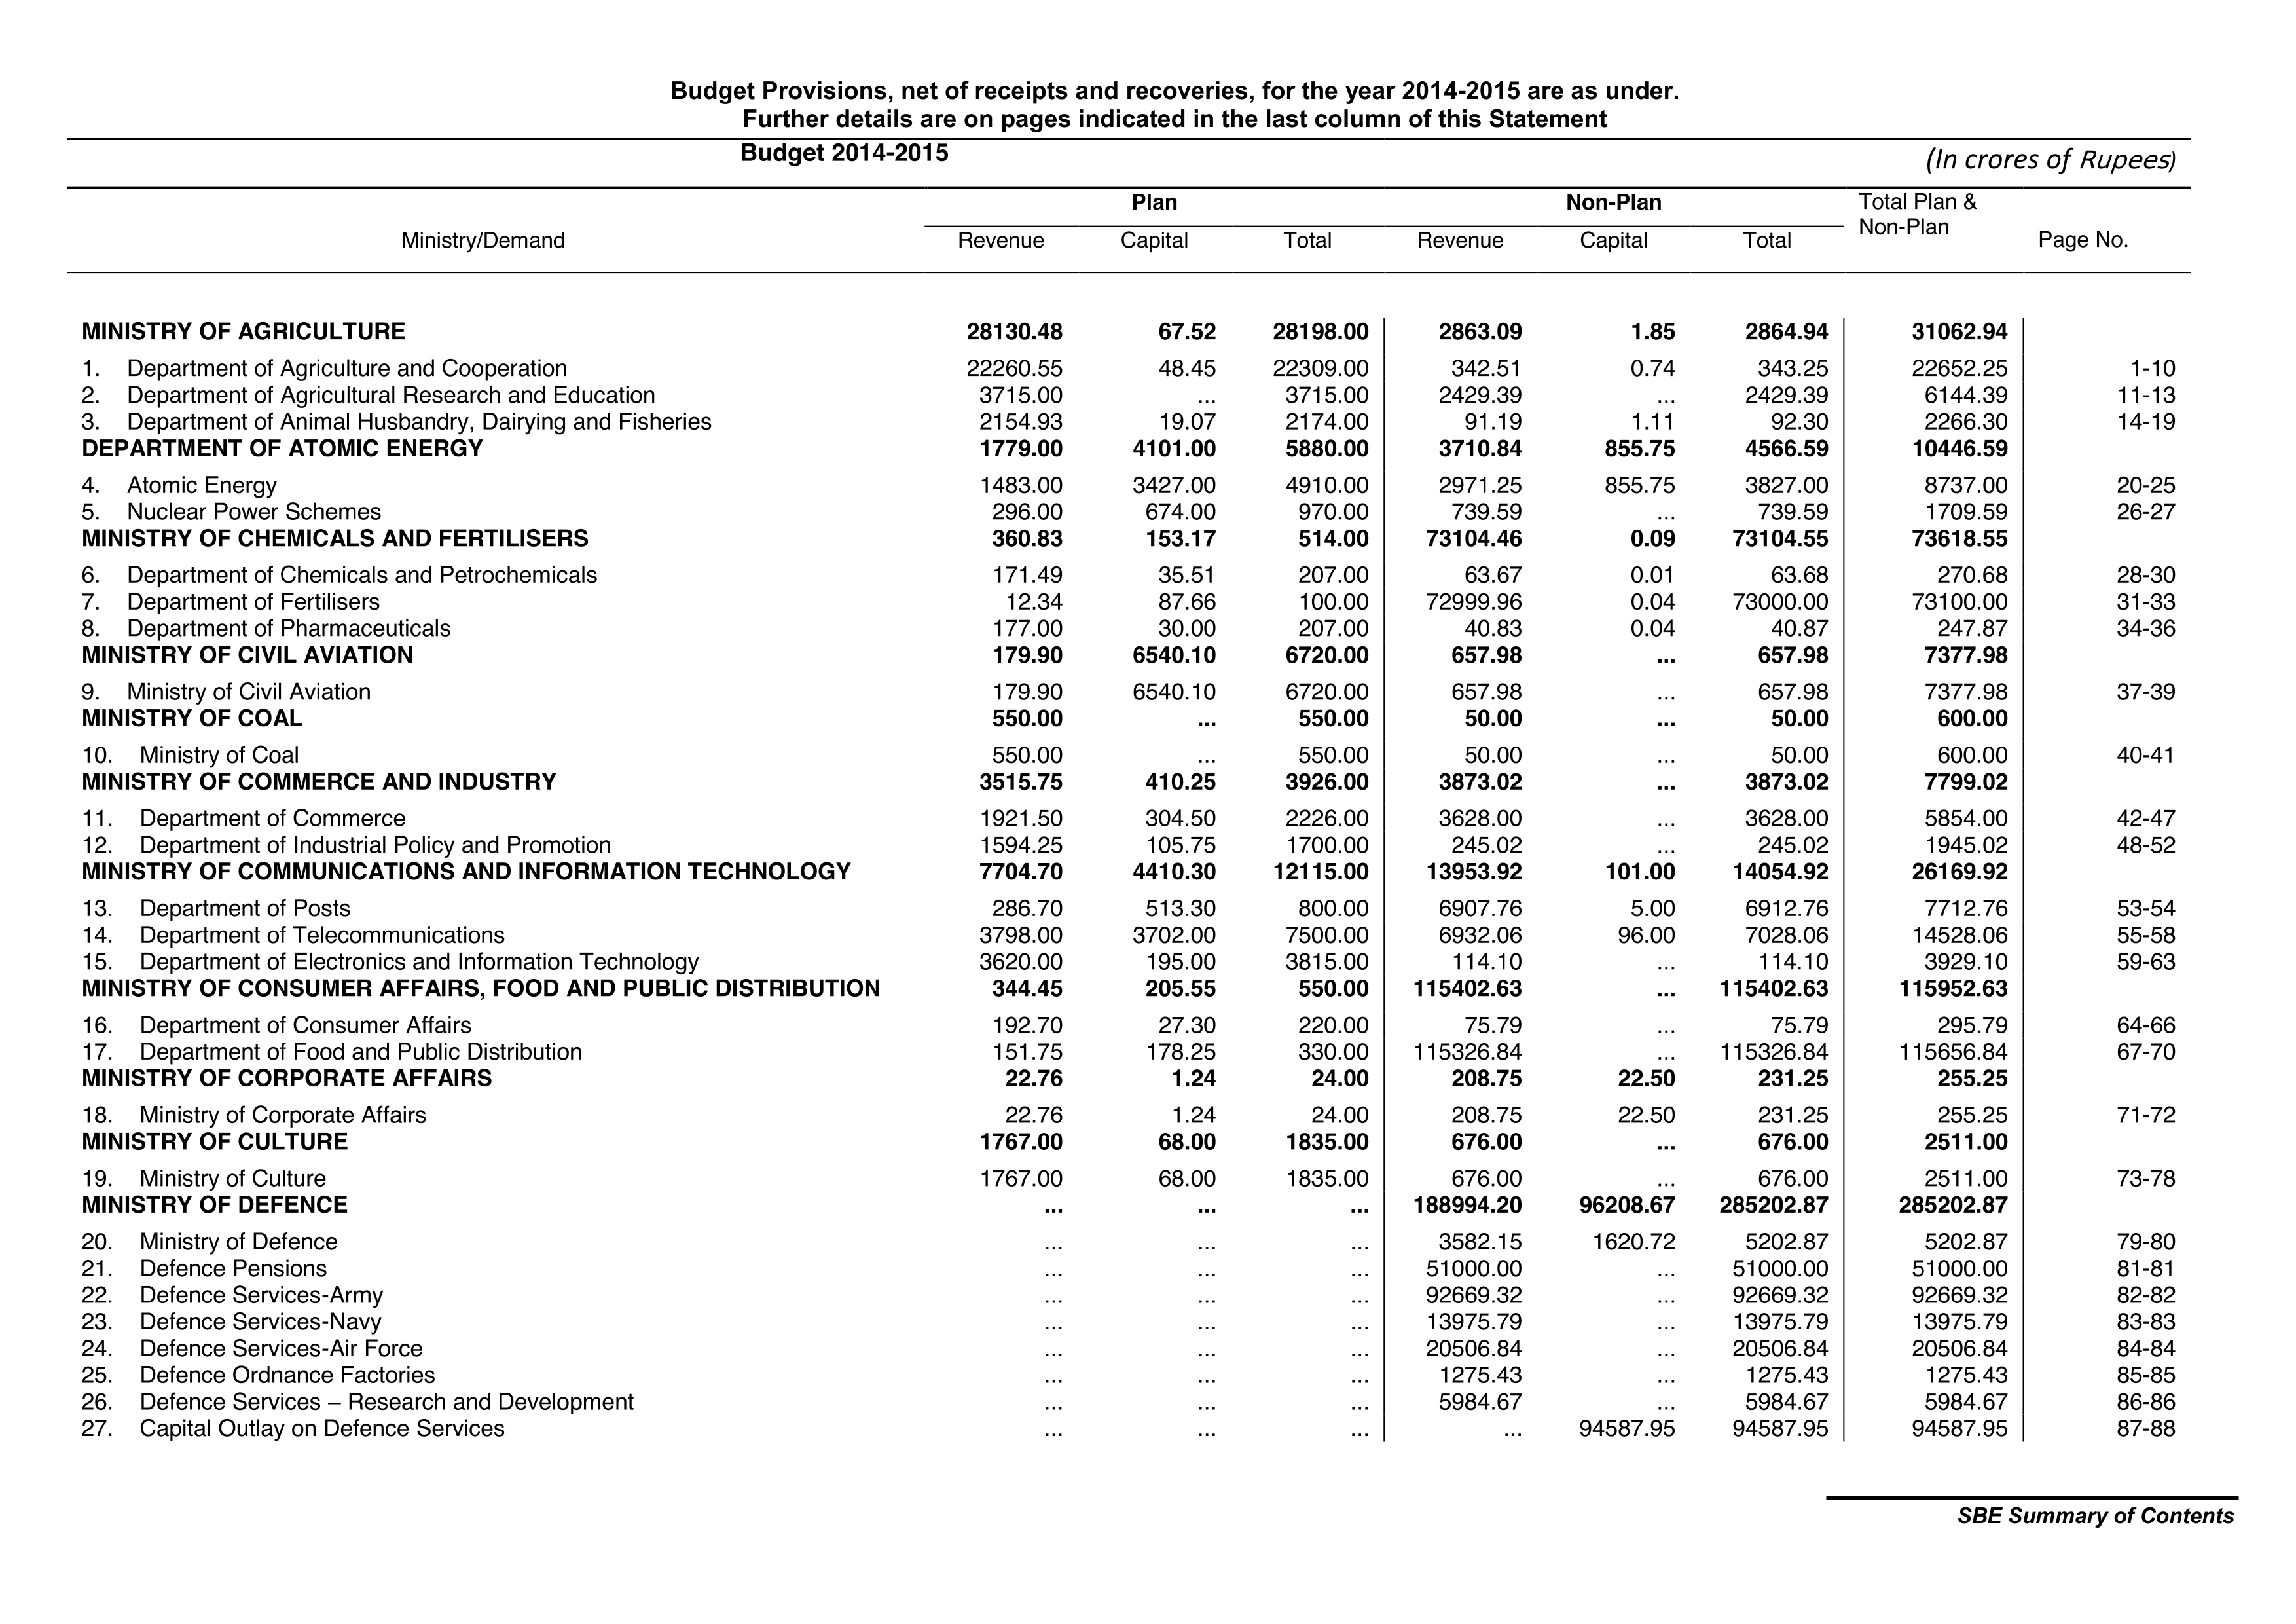

In [12]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_pdf
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f


pdf_df = spark.read.format("binaryFile").load(pdf_path)
display_pdf(pdf_df)

## Define OCR Pipeline

In [6]:
# Convert pdf to image
pdf_to_image = PdfToImage()

# Detect tables on the page using pretrained model
# It can be finetuned for have more accurate results for more specific documents
table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("region")

# Draw detected region's with table to the page
draw_regions = ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("region")
draw_regions.setOutputCol("image_with_regions")

# Extract table regions to separate images
splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")

# Detect cells on the table image
cell_detector = ImageTableCellDetector()
cell_detector.setInputCol("table_image")
cell_detector.setOutputCol("cells")
cell_detector.setAlgoType("morphops")

# Extract text from the detected cells 
table_recognition = ImageCellsToTextTable()
table_recognition.setInputCol("table_image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(3)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')


pipeline = PipelineModel(stages=[
    pdf_to_image,
    table_detector,
    draw_regions,
    splitter,
    cell_detector,
    table_recognition
])

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


## Run pipeline and show images with tables

In [7]:
results = pipeline.transform(pdf_df).cache()


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/jupyter/data/tab_pdfs/budget.pdf
    Resolution: 0 dpi
    Width: 3507 px
    Height: 2480 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


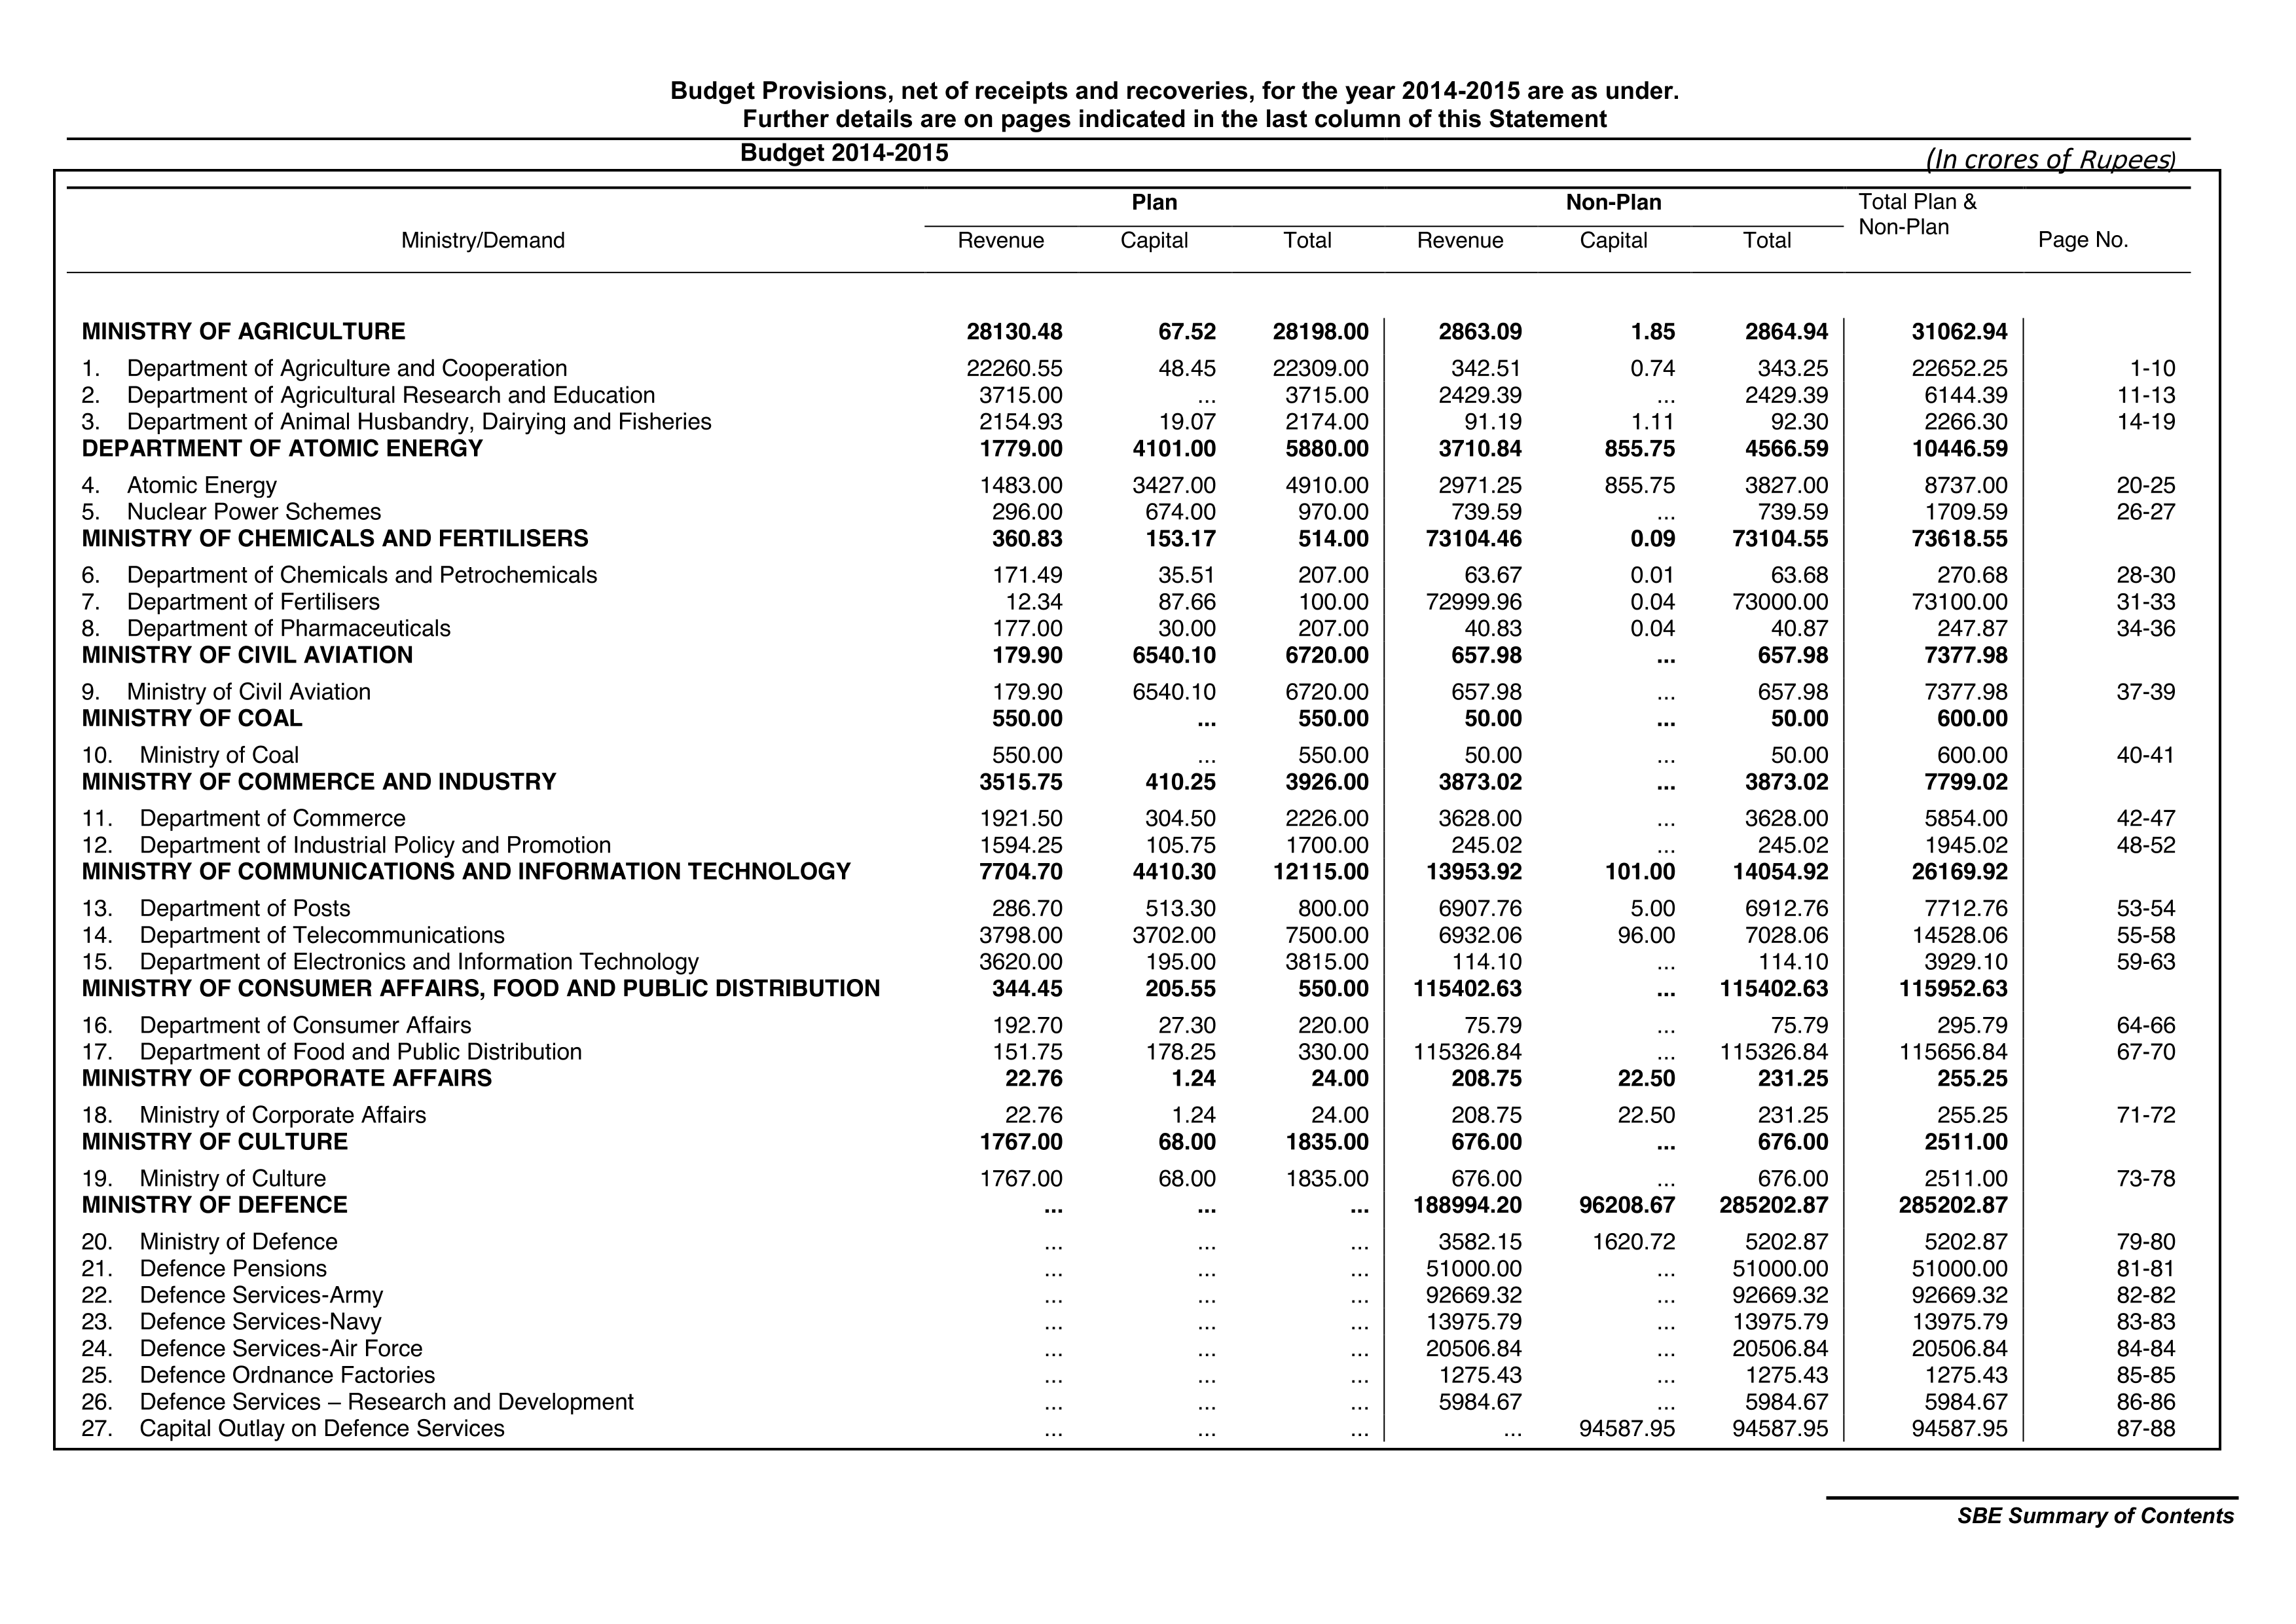

In [8]:
display_images(results, "image_with_regions", limit=10)

In [10]:
results.select("region").show(10, False)

+-------------------------------------------------+
|region                                           |
+-------------------------------------------------+
|[0, 0, 83.0, 260.0, 3308.0, 1953.0, 0.9999957, 0]|
+-------------------------------------------------+



## Show detected structured data

In [14]:
exploded_results = results.select("table", "region") \
    .withColumn("cells", f.explode(f.col("table.chunks"))) \
    .select([f.col("region.index").alias("table")] + [f.col("cells")[i].getField("chunkText").alias(f"col{i}") for i in
             range(0, 8)]) \

exploded_results.show(20, True)

+-----+--------------------+---------+-----------+----------+--------+---------------+--------+--------------------+
|table|                col0|     col1|       col2|      col3|    col4|           col5|    col6|                col7|
+-----+--------------------+---------+-----------+----------+--------+---------------+--------+--------------------+
|    0|     Ministry/Demand|  Revenue|PlanCapital|     Total| Revenue|Non-PlanCapital|   Total|Total Plan &Non-Plan|
|    0|MINISTRY OF AGRIC...| 28130.48|      67.52|28198.00 || 2863.09|           1.85| 2864.94|            31062.94|
|    0|1. Department of ...| 22260.55|      48.45|22309.00 ||  342.51|           0.74|  343.25|            22652.25|
|    0|2. Department of ...|  3715.00|           | 3715.00 || 2429.39|               | 2429.39|             6144.39|
|    0|3. Department of ...|  2154.93|      19.07| 2174.00 ||   91.19|           1.11|   92.30|             2266.30|
|    0|DEPARTMENT OF ATO...|  1779.00|    4101.00| 5880.00 || 37